#### 1. 앙상블 학습의 대표적인 학습 방법 3가지와 그 방법들 사이의 차이점을 서술하시오. 

* Voting : 서로 다른 알고리즘의 분류기를 이용하여 학습을 하고 투표를 통해서 최종 예측 결과 결정
* Bagging : 모두 같은 유형의 알고리즘의 분류기를 이용하지만, 데이터 샘플링을 서로 다르게 가져가면서(Bootstrapping) 학습을 하고 투표를 통해서 최종 예측 결과 결정
* Boosting : 여러개의 분류기가 순차적으로 학습 수행, 앞에서 학습한 분류기의 예측이 틀린 데이터에 대해서는 weight를 가하여 학습 계속 진행

#### 2. 보팅(Voting)의 유형 두가지와 그 들의 차이점을 서술하시오.

* 하트 보팅 & 소프트 보팅
* 하드 보팅 : 예측 결과를 다수결로 투표하여 결과 선정
* 소프트 보팅 : 각 분류기의 예측 결과의 확률을 평균하여 결과 선정

#### 3. 랜덤포레스트(Random Forest)의 결과 에측 과정을 간략하게 설명하시오.

전체 데이터에서 Bootstrapping을 통하여 데이터를 샘플링하고 이를 동일한 분류기들에 넣어서 소프트 보팅을 사용한다. 그 결과를 최종 클래스로 취급함.

#### 4. GBM(Gradient Boosting Machine) 알고리즘에 대해 간단히 설명하시오.

* weak learner를 순차적으로 학습-예측하면서 error data에 weight를 부여하는데, 이를 Gradient Descent 방법으로 한다.

#### 5. XGBoost(eXtra Gradient Boost) 알고리즘애 대해 간략하게 설명하고 GBM 대비 이 알고리즘의 장점에 대해 서술하시오.

* GBM에 추가적인 기능을 더한 알고리즘
* GBM 보다 수행 시간이 상대적으로 빠르고 여러가지 방향에서 보완했기에 예측 성능이 뛰어나다. 추가적인 기능으로 과적합 규제, 나무가지치기, 자체 내장 교차 검증, 결손값 자체 처리등의 장점이 있다. 

#### 6. LightGBM 알고리즘애 대해 간략하게 설명하고 XGBoost 대비 이 알고리즘의 장점에 대해 서술하시오.


* Leaf Wise 리프 중심 트리 분할 사용. 
-> 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않고, 최대한 손실값을 가지는 리프노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 배칭적인 규칙 트리 생성.
* 장점1 더 빠른 학슴과 예측 수행 시간
* 장점2 더 작은 메모리 사용
* 장점3 카테고리형 피처의 자동 변환과 최적 분할

#### 7. (Coding Part) titanic.csv 데이터를 기반으로 타이타닉호 승객 생존률을 예측하는 모델을 만들고자 한다.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/titanic.csv')
df.head(3)

,Unnamed: 0,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_S
0,0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,1,38.0,1,0,71.2833,1,0
2,2,1,3,1,26.0,0,0,7.9250,0,1


In [4]:
print('\n ### train 데이터 정보 ### \n')
print(df.info())


 ### train 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  684 non-null    int64  
 1   Survived    684 non-null    int64  
 2   Pclass      684 non-null    int64  
 3   Sex         684 non-null    int64  
 4   Age         684 non-null    float64
 5   SibSp       684 non-null    int64  
 6   Parch       684 non-null    int64  
 7   Fare        684 non-null    float64
 8   Embarked_C  684 non-null    int64  
 9   Embarked_S  684 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 53.6 KB
None


#####       (a) 생존률과 다른 independent variables 간의 상관관계를 나타내시오. 생존률과 가장 correlation이 높은 두가지 variables은 무엇인가?

####### high correlation to Survived #####
Index(['Sex', 'Fare'], dtype='object')


 ####### correlation graph #######


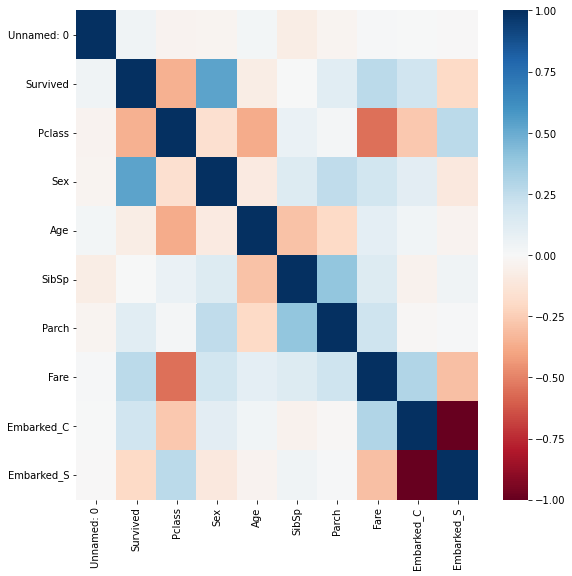

In [6]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = df.corr()

corr_Survived = corr['Survived']
corr_Survived_sort = corr_Survived.sort_values(ascending=False)
print('####### high correlation to Survived #####')
print(corr_Survived_sort[1:3].index)
print('\n\n ####### correlation graph #######')
sns.heatmap(corr, cmap='RdBu')

#####       (b) Random Forest 알고리즘을 통해 생존률을 예측하고 모델의 정확도를 나타내시오

In [11]:
fare_mean = df['Fare'].mean()
fare_median = df['Fare'].median()
print(fare_mean)
print(fare_median)

35.23456330409351
15.875


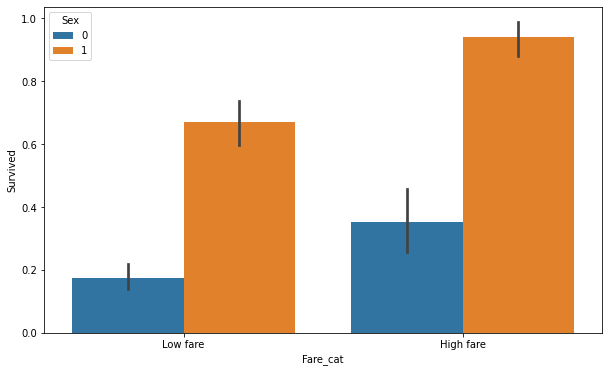

In [14]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용. 
def get_category(fare):
    cat = ''
    if fare <= fare_mean: cat = 'Low fare'
    else : cat = 'High fare'
    return cat

# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

# lambda 식에 위에서 생성한 get_category( ) 함수를 반환값으로 지정. 
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
df['Fare_cat'] = df['Fare'].apply(lambda x : get_category(x))
sns.barplot(x='Fare_cat', y = 'Survived', hue = 'Sex', data=df)

high correlation인 두개만 사용

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/titanic.csv')
df.drop(['Pclass', 'Age', 'SibSp', 'Parch', 'Embarked_C', 'Embarked_S'],axis=1,inplace=True)

y_df = df['Survived']
X_df= df.drop('Survived',axis=1)

X_train, X_test, y_train, y_test=train_test_split(X_df, y_df, test_size=0.3, random_state=2021)

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=2021)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))


랜덤 포레스트 정확도: 0.7767


correlation 관계없이 그냥 시도 

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/titanic.csv')
y_df = df['Survived']
X_df= df.drop('Survived',axis=1)

X_train, X_test, y_train, y_test=train_test_split(X_df, y_df, test_size=0.3, random_state=2021)

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=2021)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.7864


#####       (c) GridSearchCV를 사용하여  최적의 hyper-parameter를 가진 모델을 생성하고 그 모델의 최고 예측 정확도를 나타내시오.

In [23]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.7803


In [24]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.8058


#####       (d) bar plot을 사용하여 feature importance를 나타내시오.

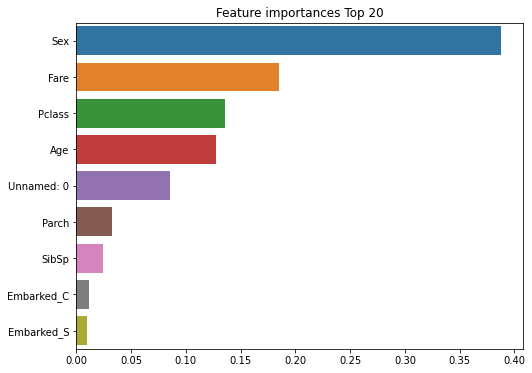

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

#####       (e) XGBoowst 래퍼를 사용하여 생존율을 예측하고 그 모델의 정확도를 나타내시오

In [26]:
import xgboost

print(xgboost.__version__)

0.90


In [27]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

네이브

In [28]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/titanic.csv')
y_df = df['Survived']
X_df= df.drop('Survived',axis=1)

X_train, X_test, y_train, y_test=train_test_split(X_df, y_df, test_size=0.3, random_state=2021)

In [29]:
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [30]:
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

In [31]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=100, evals=wlist )

[0]	train-logloss:0.648202	eval-logloss:0.647758
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.611077	eval-logloss:0.61015
[2]	train-logloss:0.580184	eval-logloss:0.578883
[3]	train-logloss:0.554157	eval-logloss:0.55214
[4]	train-logloss:0.532059	eval-logloss:0.530077
[5]	train-logloss:0.513222	eval-logloss:0.512966
[6]	train-logloss:0.496961	eval-logloss:0.496198
[7]	train-logloss:0.483831	eval-logloss:0.482174
[8]	train-logloss:0.47157	eval-logloss:0.470034
[9]	train-logloss:0.461705	eval-logloss:0.460294
[10]	train-logloss:0.452397	eval-logloss:0.450469
[11]	train-logloss:0.444254	eval-logloss:0.442786
[12]	train-logloss:0.436688	eval-logloss:0.436918
[13]	train-logloss:0.430266	eval-logloss:0.431429
[14]	train-logloss:0.424231	eval-logloss:0.425083
[15]	train-logloss:0.41968	eval-logloss:0.421035
[16]	train-logloss:0.414788	eval-logloss:0.417789
[17]	train-log

In [32]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.029 0.914 0.068 0.569 0.269 0.242 0.867 0.109 0.222 0.215]
예측값 10개만 표시: [0, 1, 0, 1, 0, 0, 1, 0, 0, 0]


In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [35]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[108  22]
 [ 15  61]]
정확도: 0.8204, 정밀도: 0.7349, 재현율: 0.8026,    F1: 0.7673, AUC:0.8955


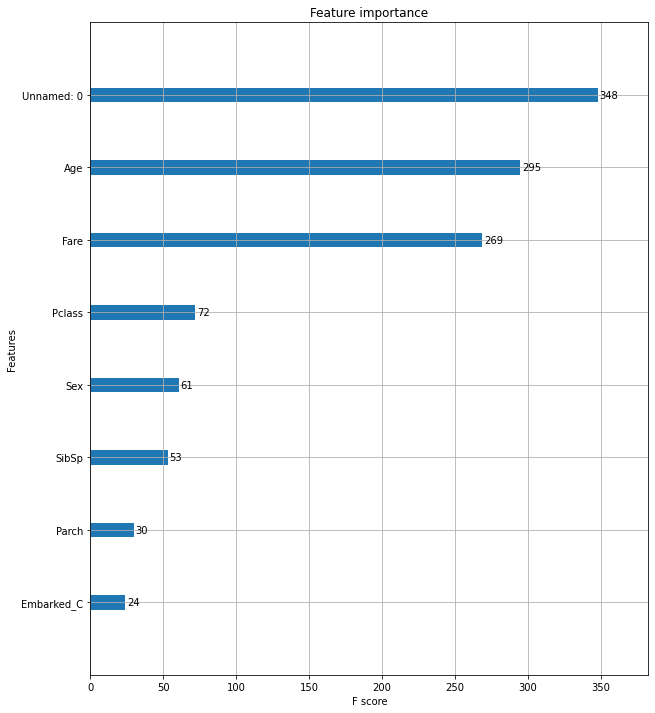

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

래퍼

In [37]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [38]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[107  23]
 [ 14  62]]
정확도: 0.8204, 정밀도: 0.7294, 재현율: 0.8158,    F1: 0.7702, AUC:0.8888


In [39]:

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.647758
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.61015
[2]	validation_0-logloss:0.578883
[3]	validation_0-logloss:0.55214
[4]	validation_0-logloss:0.530077
[5]	validation_0-logloss:0.512966
[6]	validation_0-logloss:0.496198
[7]	validation_0-logloss:0.482174
[8]	validation_0-logloss:0.470034
[9]	validation_0-logloss:0.460294
[10]	validation_0-logloss:0.450469
[11]	validation_0-logloss:0.442786
[12]	validation_0-logloss:0.436918
[13]	validation_0-logloss:0.431429
[14]	validation_0-logloss:0.425083
[15]	validation_0-logloss:0.421035
[16]	validation_0-logloss:0.417789
[17]	validation_0-logloss:0.414548
[18]	validation_0-logloss:0.412085
[19]	validation_0-logloss:0.409365
[20]	validation_0-logloss:0.408579
[21]	validation_0-logloss:0.405609
[22]	validation_0-logloss:0.405069
[23]	validation_0-logloss:0.404208
[24]	validation_0-logloss:0.401834
[25]	validation_0-logloss:0.401634
[26]	validation_0-logloss:0.40159

In [40]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차 행렬
[[110  20]
 [ 16  60]]
정확도: 0.8252, 정밀도: 0.7500, 재현율: 0.7895,    F1: 0.7692, AUC:0.9006


In [41]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.647758
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.61015
[2]	validation_0-logloss:0.578883
[3]	validation_0-logloss:0.55214
[4]	validation_0-logloss:0.530077
[5]	validation_0-logloss:0.512966
[6]	validation_0-logloss:0.496198
[7]	validation_0-logloss:0.482174
[8]	validation_0-logloss:0.470034
[9]	validation_0-logloss:0.460294
[10]	validation_0-logloss:0.450469
[11]	validation_0-logloss:0.442786
[12]	validation_0-logloss:0.436918
[13]	validation_0-logloss:0.431429
[14]	validation_0-logloss:0.425083
[15]	validation_0-logloss:0.421035
[16]	validation_0-logloss:0.417789
[17]	validation_0-logloss:0.414548
[18]	validation_0-logloss:0.412085
[19]	validation_0-logloss:0.409365
[20]	validation_0-logloss:0.408579
[21]	validation_0-logloss:0.405609
[22]	validation_0-logloss:0.405069
[23]	validation_0-logloss:0.404208
[24]	validation_0-logloss:0.401834
[25]	validation_0-logloss:0.401634
[26]	validation_0-logloss:0.401594

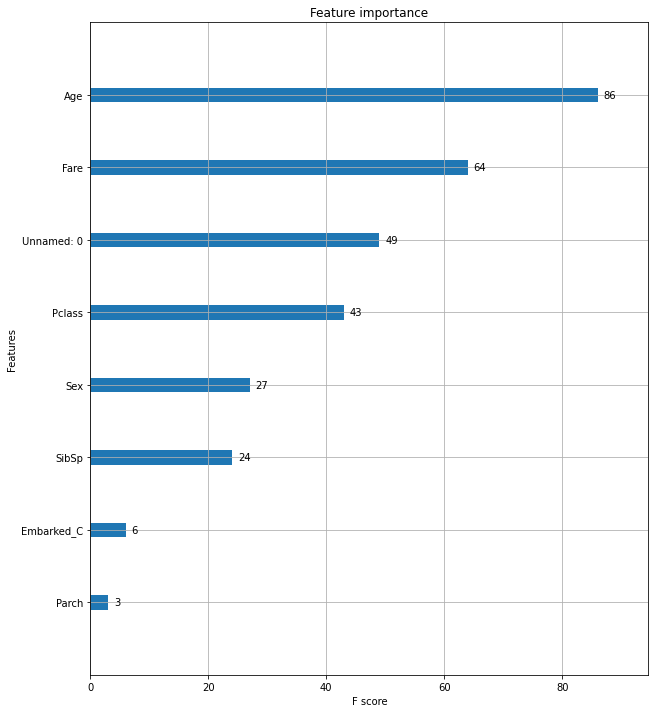

In [42]:

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)